# FireRisk Prediction Models

 Code to predict fire incidents based on data about a given address, using various machine learning models.

## Imports

In [3]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import graphviz


## Feature Engineering
Separate quantitative features, convert categorical variables to one-hot encoding

In [4]:
x = pd.read_csv('data/molly_master_11152017.csv', low_memory=False)
y = x.pop('Incident_Dummy')
y = to_categorical(y)
print "class distribution: {}".format(np.mean(y, axis=0))

# Drop EAS, as it a unique code which will not help predict fires
x = x.drop("EAS", axis=1)

for col in x.columns:
    print col

# quantitative features:

x_quant = x[['Yr_Property_Built',
       'Num_Stories', 'Num_Units', 'Perc_Ownership', 'Land_Value',
       'Property_Area', 'Assessed_Improvement_Val', 'Tot_Rooms',
       'landval_psqft', 'count_potential_fire_control', 'count_all_complaints',
       'population', 'median_age', 'avg_household_size',
       'num_housing_units', 'seasonal',
       'num_under_18', 'total_hholds', 'gini_a', 'gini_b']].copy()

x_quant['pct_vacant'] = np.where(x.num_housing_units!=0, x.vacant / x.num_housing_units, 0)

x_quant['pub_assist_income'] = np.where(x.total_hholds!=0, x.hholds_pubassist / x.total_hholds, 0)

x_quant['children'] = np.where(x.population!=0, x.num_under_18 / x.population, 0)

# and categorical features:

x_dummies = pd.get_dummies(data=x[['Neighborhood']])

x_all = pd.concat([x_quant, x_dummies], axis=1)
x_df = x_all
print x_all.shape
x_all = np.array(x_all)
mean = np.mean(x_all, axis=0)
std = np.std(x_all, axis=0)
print "feature mean: {} std: {}".format(mean, std)

x_all = x_all - mean
x_all = np.divide(x_all, std) 

x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size=.30, random_state=415)

(194763, 62)
feature mean: [1.92953096e+03 1.88794364e+00 2.91875017e+00 8.66113848e-01
 5.43886668e+05 5.45155734e+03 5.97950738e+05 1.39319871e+01
 1.41223747e+02 7.78895375e-02 1.12182499e-01 1.97565308e+02
 4.01875844e+01 2.52009172e+00 9.17502708e+01 1.08568106e+00
 2.03682008e+02 6.20444427e+02 4.67482630e-01 5.04520925e-02
 6.87816795e-02 2.30969068e-02 1.84541270e+00 4.36479208e-02
 3.80000308e-02 3.56638581e-02 1.53622608e-02 4.55168590e-02
 1.23175346e-02 1.47358585e-02 2.47428926e-02 1.93568594e-02
 2.92458013e-02 4.02129768e-02 2.05377818e-03 6.93150136e-04
 2.46453382e-04 1.84377936e-02 3.15768395e-02 4.82637873e-04
 6.65526820e-02 2.11539153e-03 1.86996503e-02 3.77433085e-02
 1.71901234e-02 3.32866099e-02 2.71458131e-02 6.22756889e-02
 2.25042744e-02 2.06199329e-02 2.01886395e-02 1.54033364e-04
 1.47769340e-02 2.21654010e-02 4.40021975e-03 1.61786376e-02
 1.22857011e-01 1.37551794e-02 9.11877513e-03 1.86020959e-02
 6.74871511e-02 9.70410191e-03] std: [2.55295631e+01 1.322

# Random Forest
Random forrest with the hyperparameters set by Molly. So far, this model is the best fit.

In [4]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=415, verbose=True)

clf.fit(x_train, y_train)

for feature in zip(x.columns, clf.feature_importances_):
    print(feature)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.7min finished


('Unnamed: 0', 0.048526338878625515)
('EAS', 0.034495346345350814)
('Yr_Property_Built', 0.03986932218866535)
('Num_Stories', 0.02510088762281809)
('Num_Units', 0.06398135686989721)
('Perc_Ownership', 0.10597499781752164)
('Land_Value', 0.07403703106712564)
('Property_Area', 0.06000052202529292)
('Assessed_Improvement_Val', 0.060554831354119716)
('Tot_Rooms', 0.03073245436399794)
('landval_psqft', 0.03097671496522528)
('count_potential_fire_control', 0.03300892779607881)
('count_all_complaints', 0.03387528438377459)
('tract', 0.042087251189332126)
('census_block', 0.03454878241390455)
('latlong', 0.012447011206775091)
('inde', 0.028334483631480327)
('county', 0.03033407264933623)
('blkgroup', 0.027346620686388965)
('rur_urb', 0.022463949546075914)
('zip', 0.027994831780995984)
('population', 0.020151638809970073)
('median_age', 0.03404940336927649)
('avg_household_size', 0.0031335508949377104)
('num_housing_units', 0.0021577742713858113)
('occupied', 0.0023235153548771398)
('vacant', 0

In [5]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.1s


             precision    recall  f1-score   support

          0       0.94      0.98      0.96     51038
          1       0.81      0.60      0.69      7391

avg / total       0.93      0.93      0.93     58429



[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    4.0s finished


# MLP with SKLearn

In [13]:
clf = MLPClassifier(max_iter=400)

clf.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [6]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
print confusion_matrix(y_true, y_pred)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    3.0s


             precision    recall  f1-score   support

          0       0.94      0.98      0.96     51038
          1       0.81      0.60      0.69      7391

avg / total       0.93      0.93      0.93     58429



[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    3.8s finished


NameError: name 'y_true' is not defined

# MLP with Keras

This model currently is not fitting any better than 0.87, which is the accuracy you'd get always choosing, "No Fire". I'm not sure if it's a hyperparameter issue, a bug with my keras implementation, or just not the right model for the problem.

In [30]:
print "building model..."
input_dim = x_train.shape[1]

model = Sequential()
model.add(Dense(256, input_dim=input_dim))
# model.add(Dropout(0.15))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.15))
model.add(Dense(2, activation="softmax"))
from keras import optimizers

# All parameter gradients will be clipped to
# a maximum norm of 1.
adam = optimizers.Adam(lr=0.01, clipnorm=1.)

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
cb = EarlyStopping(monitor='val_loss', patience=0, verbose=2, mode='auto')
print("Training...")
model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=[x_test, y_test],  verbose=2, callbacks=[cb])
# model.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=[x_test, y_test],  verbose=2, )


building model...
Training...
Train on 136334 samples, validate on 58429 samples
Epoch 1/20
 - 7s - loss: 0.3162 - acc: 0.8891 - val_loss: 0.3052 - val_acc: 0.8945
Epoch 2/20
 - 6s - loss: 0.3034 - acc: 0.8926 - val_loss: 0.3010 - val_acc: 0.8945
Epoch 3/20
 - 6s - loss: 0.3002 - acc: 0.8934 - val_loss: 0.3001 - val_acc: 0.8942
Epoch 4/20
 - 6s - loss: 0.2995 - acc: 0.8938 - val_loss: 0.2993 - val_acc: 0.8938
Epoch 5/20
 - 6s - loss: 0.2971 - acc: 0.8939 - val_loss: 0.2970 - val_acc: 0.8950
Epoch 6/20
 - 6s - loss: 0.2954 - acc: 0.8945 - val_loss: 0.2969 - val_acc: 0.8951
Epoch 7/20
 - 6s - loss: 0.2946 - acc: 0.8945 - val_loss: 0.2961 - val_acc: 0.8957
Epoch 8/20
 - 6s - loss: 0.2937 - acc: 0.8948 - val_loss: 0.2942 - val_acc: 0.8955
Epoch 9/20
 - 6s - loss: 0.2921 - acc: 0.8957 - val_loss: 0.2939 - val_acc: 0.8966
Epoch 10/20
 - 6s - loss: 0.2918 - acc: 0.8956 - val_loss: 0.2919 - val_acc: 0.8975
Epoch 11/20
 - 6s - loss: 0.2910 - acc: 0.8959 - val_loss: 0.2911 - val_acc: 0.8969
Epoc

In [20]:
print("Generating test predictions...")
preds = model.predict_classes(x_test, verbose=0)

y_test = np.argmax(y_test, axis=1)

print(classification_report(y_test, preds))
print confusion_matrix(y_true, y_pred)

Generating test predictions...
             precision    recall  f1-score   support

          0       0.90      0.98      0.94     51038
          1       0.72      0.28      0.40      7391

avg / total       0.88      0.90      0.87     58429



NameError: name 'y_true' is not defined

# Decision Tree Classifier

In [9]:
# y_train=np.argmax(y_train, axis=1)
# y_test=np.argmax(y_test, axis=1)
clf = DecisionTreeClassifier(max_depth=3, min_samples_split=2, random_state=415)

clf.fit(x_train, y_train)

# for feature in zip(x_train.columns, clf.feature_importances_):
#     print(feature)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=415,
            splitter='best')

In [10]:
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.90      0.98      0.94     51038
          1       0.67      0.27      0.39      7391

avg / total       0.87      0.89      0.87     58429

[[50035  1003]
 [ 5374  2017]]


## Vizualize tree using graphviz
Checkout: https://www.youtube.com/watch?v=b40sc7lceqs

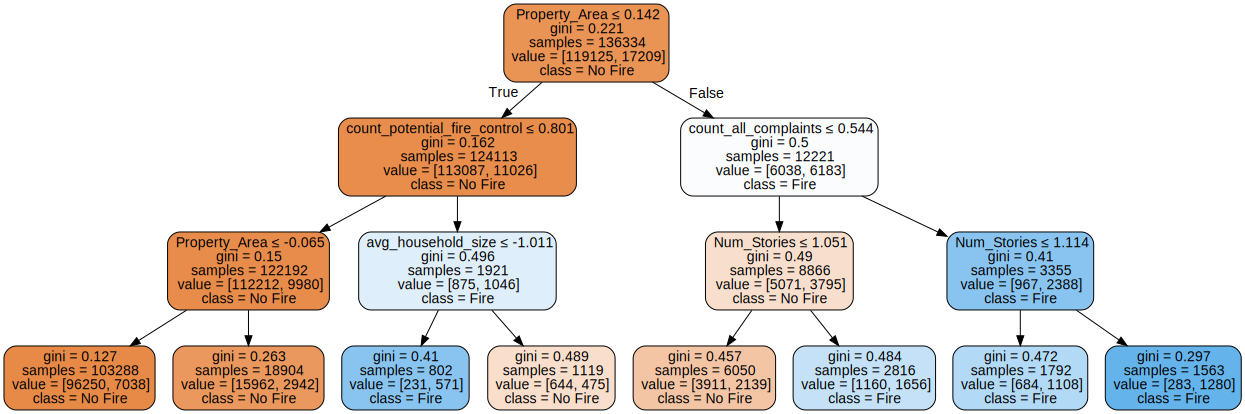

In [11]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=x_df.columns,  
                         class_names=["No Fire", "Fire"],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data)

graph.render(filename='./tree')
graph


# Logistic Regression

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y, test_size=.30, random_state=415)

clf = LogisticRegression(multi_class="ovr")
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
clf.fit(x_train, y_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
print confusion_matrix(y_true, y_pred)

             precision    recall  f1-score   support

          0       0.90      0.99      0.94     51038
          1       0.74      0.21      0.32      7391

avg / total       0.88      0.89      0.86     58429



NameError: name 'y_true' is not defined

# SVM 

In [9]:
clf = svm.SVC(verbose=True)
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
clf.fit(x_train, y_train)  

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [12]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.90      0.99      0.94     51038
          1       0.74      0.21      0.32      7391

avg / total       0.88      0.89      0.86     58429

[[50490   548]
 [ 5869  1522]]


In [ ]:
x_quant.head()